# Report

#### Group Member:

Yao Ouyang(yo2394), Zihan Chen (zc2888), Jingyang Zhang(jz3985)

#### GitHub Link:
https://github.com/Nutellaajr/state-demographics-income-analysis.git

#### Contribution:
Yao Ouyang(yo2394): Data Acquisition, Data Cleaning, Preprocessing and Feature Engineering, Report.

Jingyang Zhang(jz3985): EDA, Report.

Zihan Chen(zc2888): Data Cleaning, Preprocessing and Feature Engineering, Report.

---

# Introduction and Dataset Description

## Introduction

This project studies how demographic structure (age and sex composition) relates to economic conditions across U.S. states, using **state-level population estimates** and **median household income** data. Because the income series is only available for a short window (2021–2023 in our collected dataset), our analysis emphasizes **cross-sectional comparisons across states** and **short-run changes** rather than long-horizon time-series modeling.

Specifically, we aim to:
- Compare income levels across states within each year
- Examine year-to-year changes in income and how unevenly states recover or slow down across 2021–2023
- Provide a clean, well-structured dataset that supports downstream EDA and feature engineering (e.g., age grouping, within-state deviations, growth rates)


## Dataset Description

### Data Sources (U.S. Census Bureau APIs)

We collected data from two official Census Bureau API products:

1. **Population Estimates Program (PEP) — Characteristics of the Population (CHarV)**
   - Endpoint: `https://api.census.gov/data/2023/pep/charv`
   - Purpose: provides annual **population counts by state, year, age, and sex**

2. **American Community Survey (ACS) 1-year estimates**
   - Endpoint pattern: `https://api.census.gov/data/{year}/acs/acs1`
   - Purpose: provides annual **median household income** by state
   - Variable used: `B19013_001E` (median household income in the past 12 months)

### Key Variables

After merging, the working dataset contains:
- `State_name` / `NAME`: state name  
- `State_code` / `STATE`: 2-digit FIPS code (as a string, zero-padded)  
- `Year` / `YEAR`: year (integer)  
- `Population` / `POP`: population count  
- `Age` / `AGE`: Census age code (includes “All ages” and grouped/single-year codes)  
- `Sex` / `SEX`: sex category code  
- `Median_household_income` / `median_hh_income`: ACS median household income  

### Analytical Time Window

The population endpoint includes multiple years, but the ACS median household income data were collected for **2021–2023**. To maintain consistent coverage across variables, the final analytic dataset focuses on **2021–2023** (rows outside this window that create missing income values are excluded during preprocessing).

---

# Data Acquisition Methodology

## Overview of Workflow

Data acquisition followed a reproducible API-based pipeline:

1. Send HTTP GET requests to the Census API endpoints  
2. Parse JSON responses into pandas DataFrames  
3. Clean and standardize key fields used for merging (state codes, year types)  
4. Concatenate yearly ACS income pulls (2021–2023) into one table  
5. Merge population and income tables on `(STATE, YEAR)`  
6. Export the merged dataset for downstream cleaning/EDA/feature engineering


## Population Data Collection (PEP CHarV)

We used the **PEP 2023 CHarV** endpoint:

- Endpoint: `https://api.census.gov/data/2023/pep/charv`
- Query parameters:
  - `get = NAME, STATE, YEAR, POP, AGE, SEX`
  - `for = state:*`

This returns a table of population estimates by state, year, age, and sex. The response is returned as JSON, where the first row contains column names and subsequent rows contain values. We convert it into a DataFrame using:

- `pd.DataFrame(data[1:], columns=data[0])`


## Median Household Income Collection (ACS 1-Year)

We collected state-level median household income from **ACS 1-year** for each year in `{2021, 2022, 2023}`:

- Endpoint pattern: `https://api.census.gov/data/{year}/acs/acs1`
- Query parameters:
  - `get = NAME, B19013_001E`
  - `for = state:*`

For each year:
- We request the data, parse the JSON, and convert it to a DataFrame.
- We add a `YEAR` column to label the observation year.
- We rename `B19013_001E` to a readable column name (e.g., `median_hh_income`).
- We convert `median_hh_income` to numeric with `errors="coerce"` to safely handle any non-numeric values.

Finally, we concatenate yearly tables into one ACS income dataset:

- `pd.concat([...], ignore_index=True)`


## Key Standardization Before Merge

To ensure a correct join across sources, we standardized:
- `STATE` as a **two-digit zero-padded string** using `.astype(str).str.zfill(2)`
- `YEAR` as **integer** using `.astype(int)`

This prevents mismatches such as `"1"` vs `"01"` and string vs integer year keys.


##  Dataset Merge and Export

We merged the population table with the ACS income table using:
- keys: `STATE`, `YEAR`
- join type: **left join** on the population dataset (to preserve demographic detail)

Example logic:
- `pop_df.merge(acs_income[["STATE","YEAR","median_hh_income"]], on=["STATE","YEAR"], how="left")`

The merged dataset was then exported to a CSV file (without index) for reproducibility:
- `merged_df.to_csv("merged_dataset.csv", index=False)`

This exported dataset is used in subsequent steps (cleaning, EDA, feature engineering, and reporting).


## Cleaning and Preprocessing Steps

After merging the population dataset with the ACS median household income dataset, we performed several cleaning and preprocessing steps to ensure consistency, remove redundancy, and prepare the data for analysis.

### 1. Initial Data Inspection
We first checked the basic structure of the merged dataset using `shape`, `columns`, and `describe(include='all')`. The merged dataset initially contained **90,480 rows and 8 columns**, including:
- `NAME`, `STATE`, `YEAR`
- `POP`, `AGE`, `SEX`
- `state` (duplicate column)
- `median_hh_income`

This inspection step helped identify naming inconsistencies, missing income values (for years not covered by ACS income), and redundant columns.

### 2. Column Renaming and Removing Redundancy
To improve readability and enforce consistent naming conventions, we renamed variables:
- `NAME` → `State_name`
- `STATE` → `State_code`
- `YEAR` → `Year`
- `POP` → `Population`
- `AGE` → `Age`
- `SEX` → `Sex`
- `median_hh_income` → `Median_household_income`

We also removed the duplicate `state` column to avoid confusion and redundancy.

### 3. Data Type Standardization
To ensure correct interpretation and enable reliable numerical operations, we standardized data types:
- `Year` was converted to integer
- `Population` and `Median_household_income` were converted to numeric
- `State_code` was formatted as a two-digit string using zero-padding (e.g., `"01"`)
- `State_name` and `Sex` were converted to categorical variables

These conversions ensure uniform formatting and make later grouping/aggregation steps more reliable.

### 4. Handling Missing Values via Year Filtering
Because ACS median household income is only available for **2021–2023**, the merged dataset contains missing income values for earlier years (e.g., 2020). Instead of imputing income, we restricted the dataset to years where income data exists:

- Filtered the dataset to include only `Year >= 2021`

After filtering, we ran a missing-value check and confirmed there were **no remaining missing values** in the cleaned dataset.

### 5. Removing Duplicate Rows
We removed any duplicated observations using `drop_duplicates()` and verified that:
- **0 duplicate rows** remained after cleaning.

### 6. Validating Income Structure at the State–Year Level
Finally, we validated that median household income is measured at the **state–year level** (not age- or sex-specific). We confirmed that within each `(State_code, Year)` pair, the income variable has **at most one unique value**. This matches the expected structure: income is constant across age/sex subgroups within the same state and year because it is merged onto demographic population records for analysis.

### Final Clean Dataset
The cleaned dataset:
- Includes only years **2021–2023**
- Has consistent column names and standardized data types
- Contains no missing values and no duplicate rows
- Preserves the correct state–year structure for median household income

This dataset is now ready for downstream EDA and feature engineering.


---

# EDA

This section presents a comprehensive exploratory data analysis (EDA) aimed at understanding the
structure, distributional properties, and temporal patterns of the dataset. The EDA serves as a
foundation for subsequent statistical modeling by examining key variables, summary statistics, and
graphical evidence.

## Data Structure and Variables

The cleaned dataset consists of 40,248 observations and 8 variables capturing demographic and
economic characteristics across U.S. states over multiple years. Categorical variables include state
identifiers and age group classifications, while numerical variables include year, population
measures, and median household income.


## Summary Statistics

Summary statistics reveal meaningful variation in median household income across states and years.
The mean median household income is $72,802, while the median is $71,680, indicating that the
distribution is only mildly skewed rather than dominated by extreme values. The close proximity of the
mean and median suggests that central tendency measures provide a stable representation of
income levels across states.

## Distribution Patterns


### 1. Income Distribution Shape Analysis

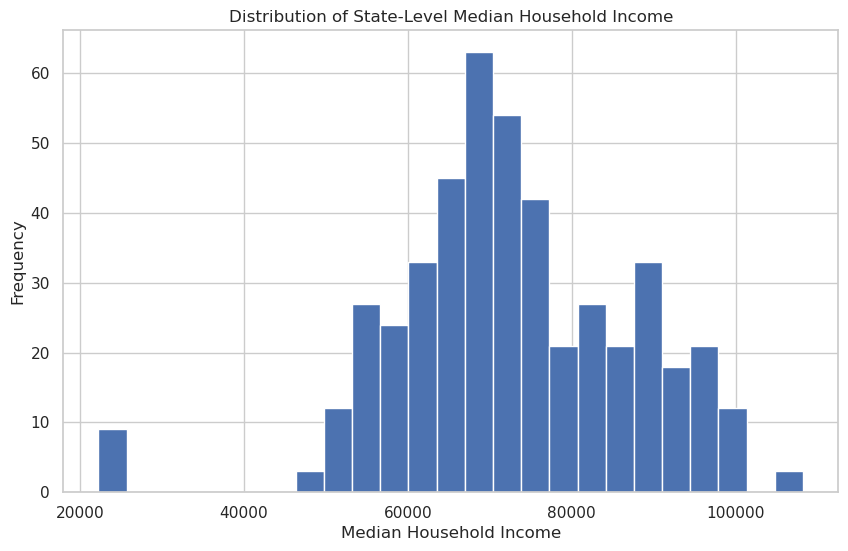

Figure 1. Distribution of state-level median household income

Figure 1 shows that most observations cluster between approximately $60,000 and $85,000, with a
small number of lower-income states extending the left tail. This pattern is consistent with mild
negative skewness and indicates that extreme values do not dominate the overall distribution.

### 2. Income Boxplot Analysis

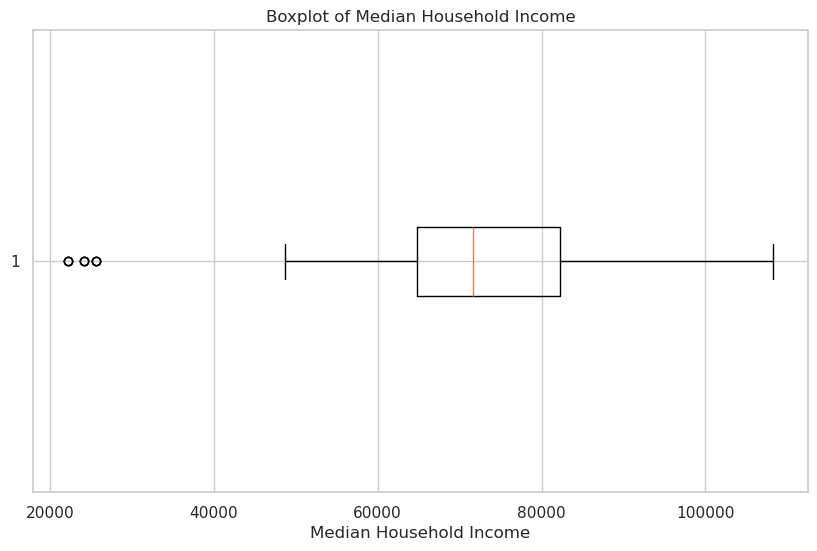

Figure 2. Boxplot of median household income.

Figure 2 confirms the presence of a mildly left-skewed distribution, with several lower-income outliers
visible below the first quartile. The relatively compact interquartile range further suggests that the
majority of states fall within a narrow income band.

## Temporal Trends



### 1. Trend in Median Household Income Over Time

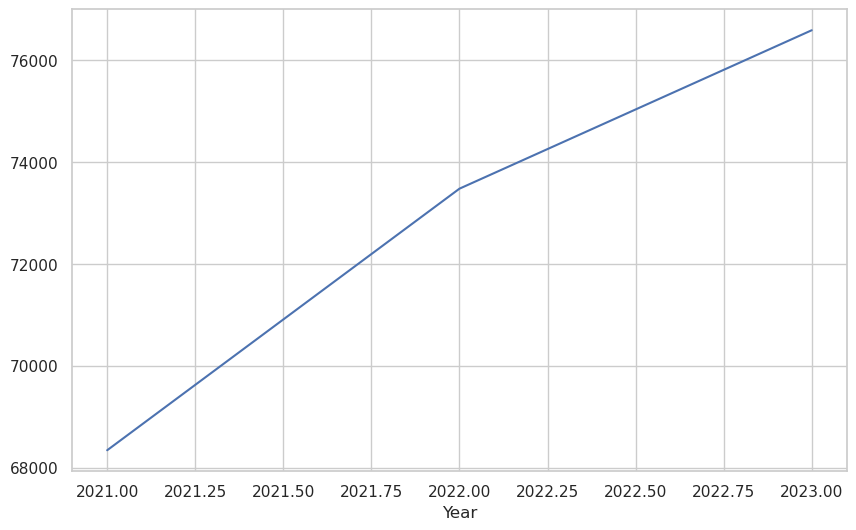

Figure 3.  Trend in median household income over time.

Figure 3 illustrates a clear upward trend in median household income from 2021 to 2023. The
increase is steady, with the largest growth occurring between 2021 and 2022, followed by continued
but slightly slower growth thereafter. This pattern suggests sustained economic improvement rather
than short-term volatility.

### 2. Income vs. Population Analysis

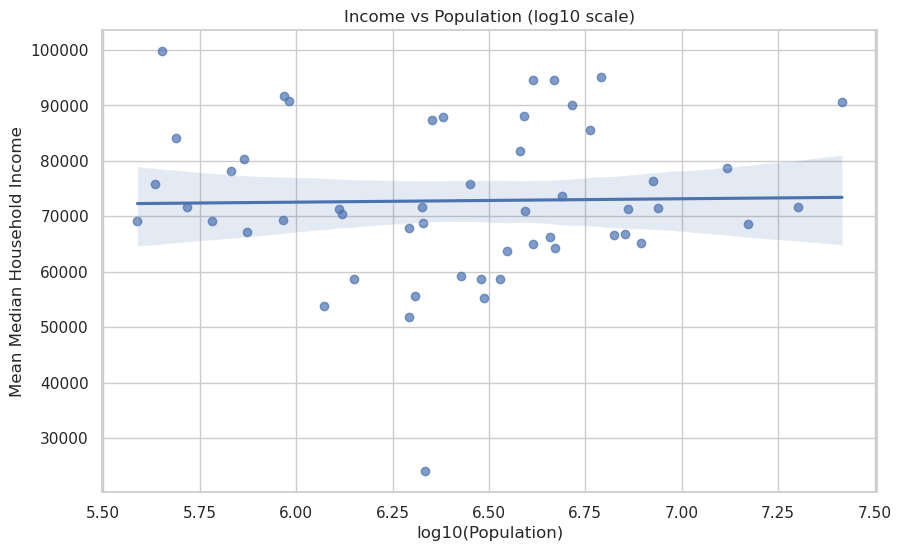

Figure 4.  Median household income versus population size (log10 scale).


Figure 4 examines the relationship between median household income and state population size
using a logarithmic population scale. The fitted regression line is nearly flat, and the substantial
dispersion of observations around the line indicates that population size is only weakly related to
income levels. States with similar population sizes often exhibit markedly different median household
incomes, suggesting that population scale alone does not explain cross-state income variation.

### 3. Heatmap of median household income

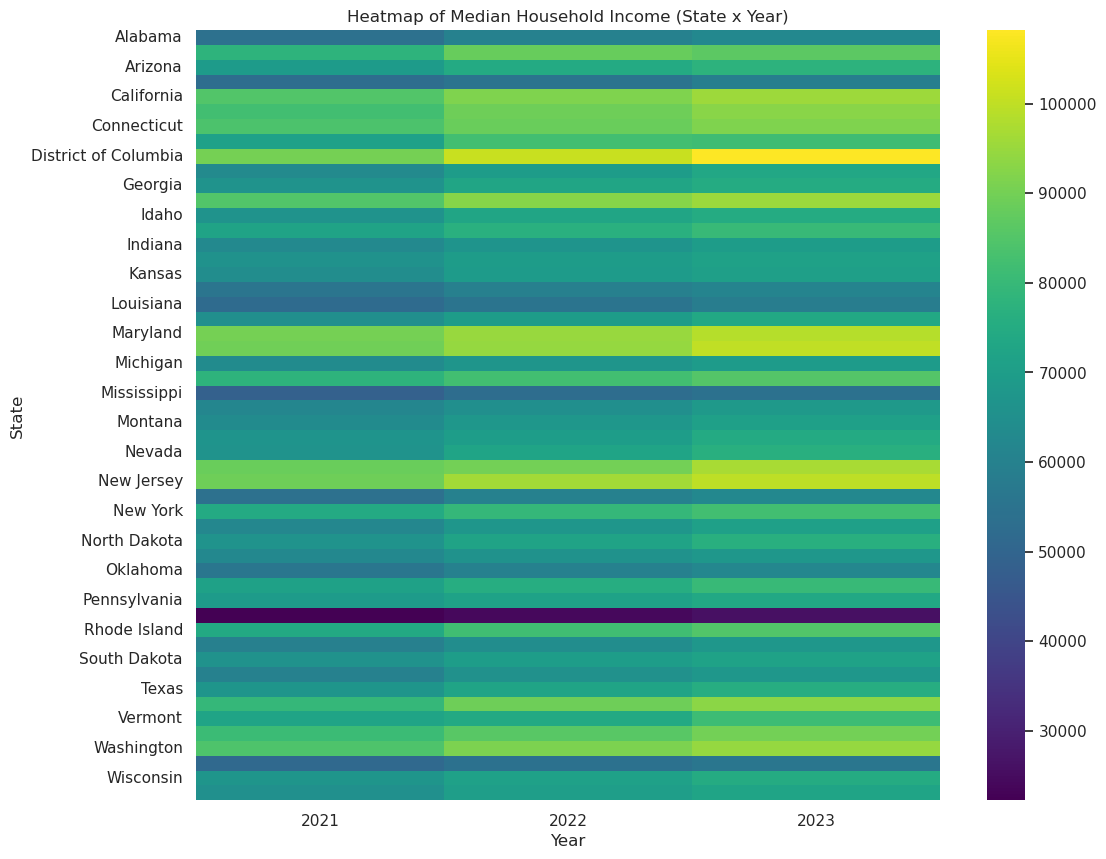

Figure 5. Heatmap of median household income by state and year.

Figure 5 presents a heatmap of median household income across states and years, providing a joint
view of temporal and regional variation. The heatmap reveals persistent cross-state heterogeneity,
with certain states consistently exhibiting higher income levels over time, while others remain at the
lower end of the distribution. At the same time, most states display a gradual increase in income
across years, indicating a broadly shared upward trend rather than isolated growth.

### 4.  Median household income by age group

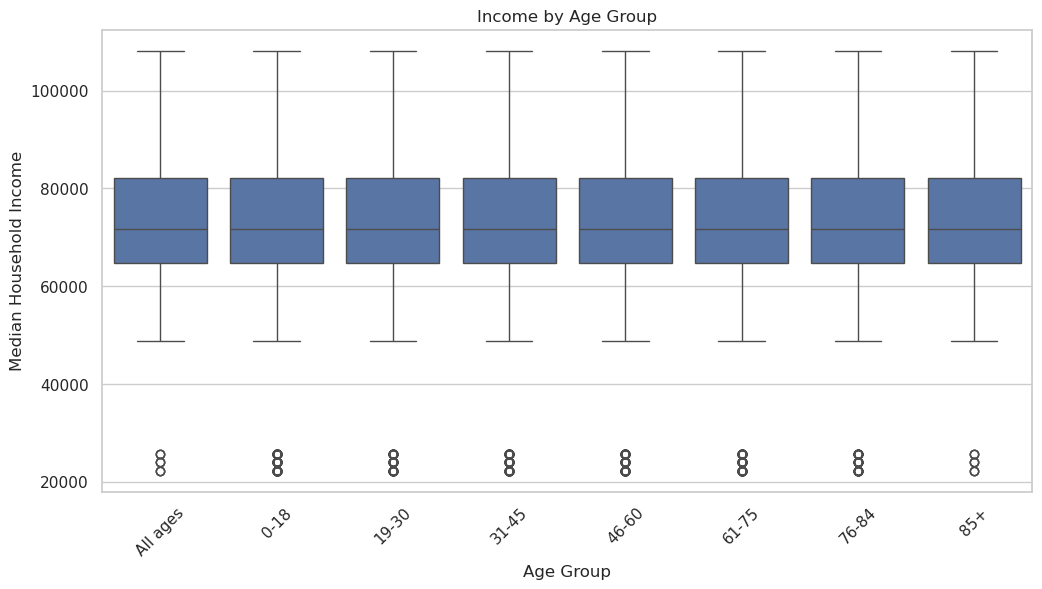

Figure 6.  Median household income by age group.

Figure 6 compares the distribution of median household income across age groups. The boxplots
show substantial overlap in medians and interquartile ranges across groups, indicating that income
distributions are highly similar by age at the state level. This suggests that age-related income
differences are modest relative to broader cross-state variation, and that regional economic factors
likely play a more dominant role than age composition in explaining differences in median household
income. Consequently, age group may be better treated as a secondary explanatory factor in
subsequent analyses.

---

# Feature Engineering Process

This section describes the feature engineering steps applied to enhance interpretability, reduce noise, and improve cross-sectional comparability across states and years.



## 1. Age Code Transformation and Age Group Construction

### Filtering Valid Age Codes

The original `Age` variable contains detailed census-style age codes (e.g., `"0100"`, `"0200"`, `"8599"`), including aggregate categories:

- `"0000"` — All ages  
- `"8599"` — 85 years and over  

To ensure consistency and remove unnecessary granularity, we retained:

- All ages (`"0000"`)
- 85+ (`"8599"`)
- Single-year age groups ending in `"00"` (e.g., `"0100"`, `"0200"`, ..., `"8400"`)

This filtering step removes ambiguous or intermediate codes while preserving meaningful demographic structure.



### Converting Age Codes to Numeric Values

We converted valid age codes into numeric age values:

- `"0000"` → `NaN` (aggregate category)
- `"8599"` → `85` (representing 85+)
- `"XX00"` → `XX` (first two digits extracted)

This transformation allows age to be treated as a numeric variable for grouping and analysis.


### Creating Interpretable Age Labels

A readable `Age_label` variable was created:

- `"0000"` → `"All ages"`
- `"8599"` → `"85+"`
- Other ages → corresponding numeric age values as strings

This improves clarity in tables and visualizations.


### Constructing Broader Age Groups

To reduce excessive granularity and improve demographic interpretability, single-year ages were grouped into broader life-stage intervals:

- 0–18  
- 19–30  
- 31–45  
- 46–60  
- 61–75  
- 76–84  
- 85+  

The `"All ages"` category was retained separately for aggregate-level analysis.


#### Justification

Single-year age data may:

- Introduce noise in cross-sectional comparisons  
- Create sparsity in smaller population groups  
- Reduce clarity in visualization  

Grouping ages into meaningful intervals achieves:

- More stable population aggregation  
- Clearer demographic interpretation  
- Reduced sparsity  
- Improved usability in visualization and comparative analysis  

This transformation enhances structural clarity while preserving essential demographic patterns.



## 2. Relative Income Measures

Median household income is measured at the state–year level. Direct comparisons across years may be influenced by national economic trends.

To improve interpretability, two additional income features were constructed.


### Income Relative to National Mean

For each year, the national average income was computed, and the following variable was defined:

Income Relative to National = State Income − National Mean Income (same year)

**Purpose:**

- Removes overall national time trends  
- Highlights each state's relative economic standing  
- Improves cross-sectional comparison within a year  


### Standardized Income (Z-score Within Year)

Income was also standardized within each year:

Z = (Income − Yearly Mean) / Yearly Standard Deviation

**Purpose:**

- Expresses income in standard deviation units  
- Enables scale-free comparison  
- Facilitates outlier detection  
- Improves interpretability in statistical modeling  



## 3. Within-State Income Deviation

To capture temporal income variation within each state, we engineered a new feature named income_within_state, defined as the deviation of a state’s yearly median household income from its own long-run mean.

This transformation was computed by first calculating each state’s multi-year average income, and then subtracting this baseline from the income observed in each specific year. The resulting variable quantifies whether a state is performing above, below, or in line with its typical income level.

This feature is valuable for several reasons:

- Normalizes structural cross-state differences:
states differ substantially in absolute income levels (e.g., Mississippi vs. Maryland). Raw income values cannot distinguish long-term structural differences from short-term fluctuations. By centering each state around its own mean, we isolate within-state temporal dynamics rather than cross-state disparities.

- Captures economic shocks and cycles: 
this feature allows us to identify years where a state experiences unusual economic conditions—either positive jumps or negative downturns relative to its historical pattern.

- Improves interpretability for time-series comparisons:
since the mean of this feature for every state is exactly 0, it becomes straightforward to compare trends across states without the noise from differences in base income levels.

- Preserves meaningful variation:
unlike standardization across the entire dataset, deviation-from-mean retains the natural units (dollars), making interpretation more intuitive.

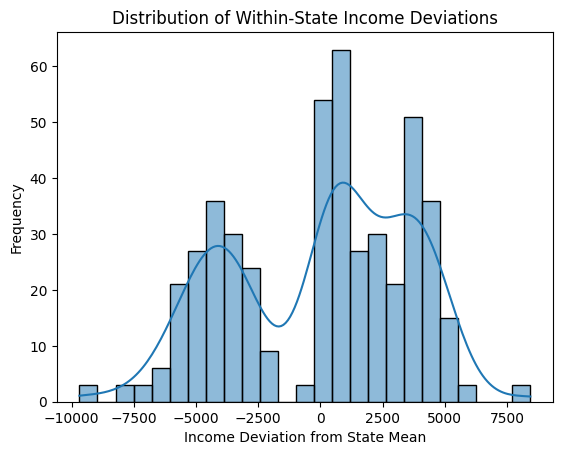

Figure 7. Within-state income deviation distribution

From the histogram and density curve, several insights emerge:

- Mean ≈ 0, as expected by construction.

- The distribution exhibits mild bimodality, suggesting heterogeneous economic behavior across states.

- Deviations range roughly from –8,000 to +8,000, indicating substantial yearly variation in income relative to historical baselines.

- The presence of both positive and negative tails reflects asymmetric economic adjustments across states—some states experience temporary downturns, while others exhibit sharp income expansions.

This confirms that the feature successfully captures intra-state economic volatility rather than absolute differences across states.

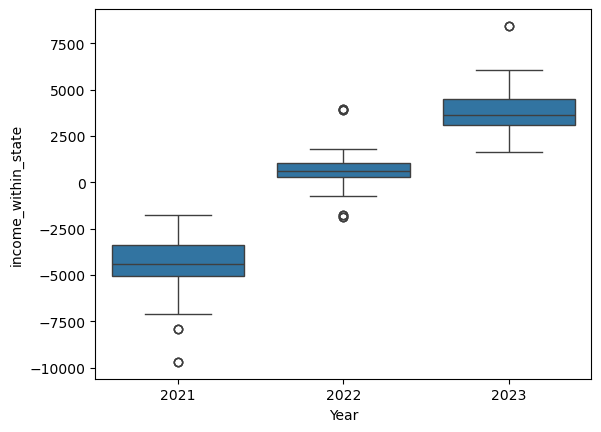

Figure 8. Year-to-year distribution

The year-wise boxplot reveals a clear temporal pattern:

- 2021: Deviations are mostly negative, indicating that many states performed below their multi-year average during this period.

- 2022: The distribution shifts upward, with most states clustering near zero or slightly positive values—suggesting a post-pandemic recovery phase.

- 2023: Deviations become strongly positive for most states, pointing toward continued economic growth and stabilization.

This temporal structure reinforces that the engineered feature is sensitive to macroeconomic changes over time while controlling for long-run differences across states.

## 4. Income Growth Rate

To capture how rapidly each state’s median household income is changing over time, we construct the variable income_growth_rate, defined as the year-over-year percentage change in median household income within each state.

This feature is computed using a within-state groupby operation followed by .pct_change() to ensure that each state’s growth trajectory is evaluated relative to its own previous income level.

The reason why we create this feature is that income growth rate is a fundamental economic indicator that measures how quickly a regional economy is expanding. While absolute income levels capture differences between states, growth rates reveal dynamic economic momentum:

- States with high positive growth likely experience favorable labor markets, business expansion, or population inflow.

- States with negative growth may face economic contraction, inflation pressure, declining industries, or demographic outflow.

- Growth rates also provide a standardized comparison, since percentage changes are scale-invariant and not biased by larger or smaller absolute income levels.

Thus, income_growth_rate complements the static income-based features by introducing a temporal dimension critical for understanding short-term and long-term economic resilience.


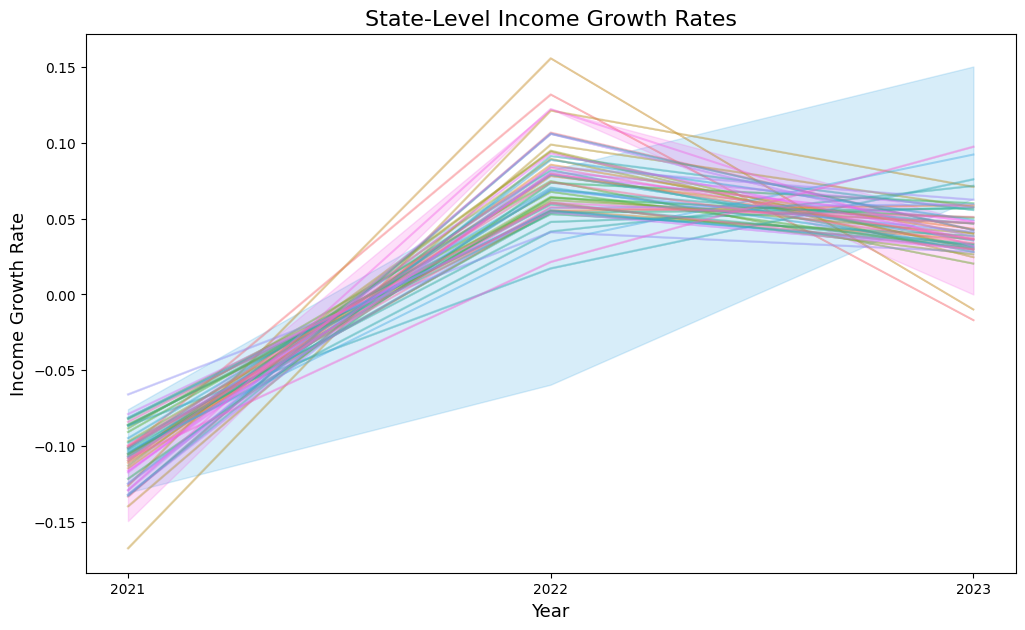

Figure 9. Yearly income growth rate

The plot reveals several clear patterns:

- 2021 shows predominantly negative growth, suggesting widespread income contraction following COVID-19 economic shocks and inflationary pressures.

- 2022 features a strong and widespread positive jump, with most states experiencing income recoveries between 5% and 15%.

- 2023 displays stabilization, where growth levels remain positive but moderate, indicating post-recovery consolidation rather than continued acceleration.

The high density of overlapping lines reflects significant heterogeneity, but the collective direction of movement remains consistent across states.

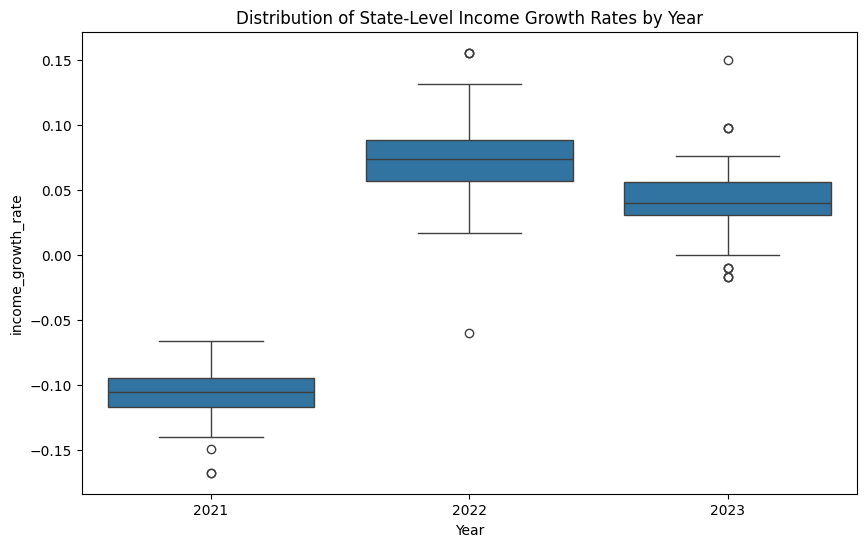

Figure 10. Income growth rate boxplot

The year-wise boxplot provides a clearer summary of central tendencies and variation:

- 2021:

  - Median growth rate is well below zero.

  - Wide spread (approx. –15% to –3%).

  - Outliers indicate certain states experienced especially sharp contractions.

- 2022:

  - Strong positive median (~7–10%).

  - Increased variability relative to 2023, reflecting differing speeds of economic recovery.

  - Several extreme high-growth outliers (above 15%).

- 2023:

  - Moderate positive median (~4%).

  - Reduced variance relative to 2022.

  - Fewer extreme outliers, signaling a return to more typical levels of income change.

Together, these results demonstrate that 2022 is a year of accelerated economic rebound, whereas 2023 marks a normalization phase.

## 5. Income Volatility (Coefficient of Variation)

To quantify how unstable or volatile income levels are within each state, we compute the coefficient of variation (CV). 	​


For each state, we group by State_name, calculate the mean and standard deviation of median household income (across 2021–2023), and compute CV as:

cv = std / mean

This yields a scale-adjusted measure of volatility, enabling direct comparison across states with very different income levels.


CV provides a more meaningful measure of income instability than raw standard deviation because:

- States with higher absolute income also naturally have higher dispersion; CV adjusts for this.

- CV captures relative income variability, not just dollar differences.

- High CV values indicate larger year-to-year swings, which may reflect:

  - reliance on volatile industries,

  - economic shocks,

  - demographic change,

  - policy-driven effects.

- Low CV values signal stable income growth, implying economic resilience.

Thus, CV is a useful metric for evaluating economic stability and comparing volatility across states with very different income baselines.

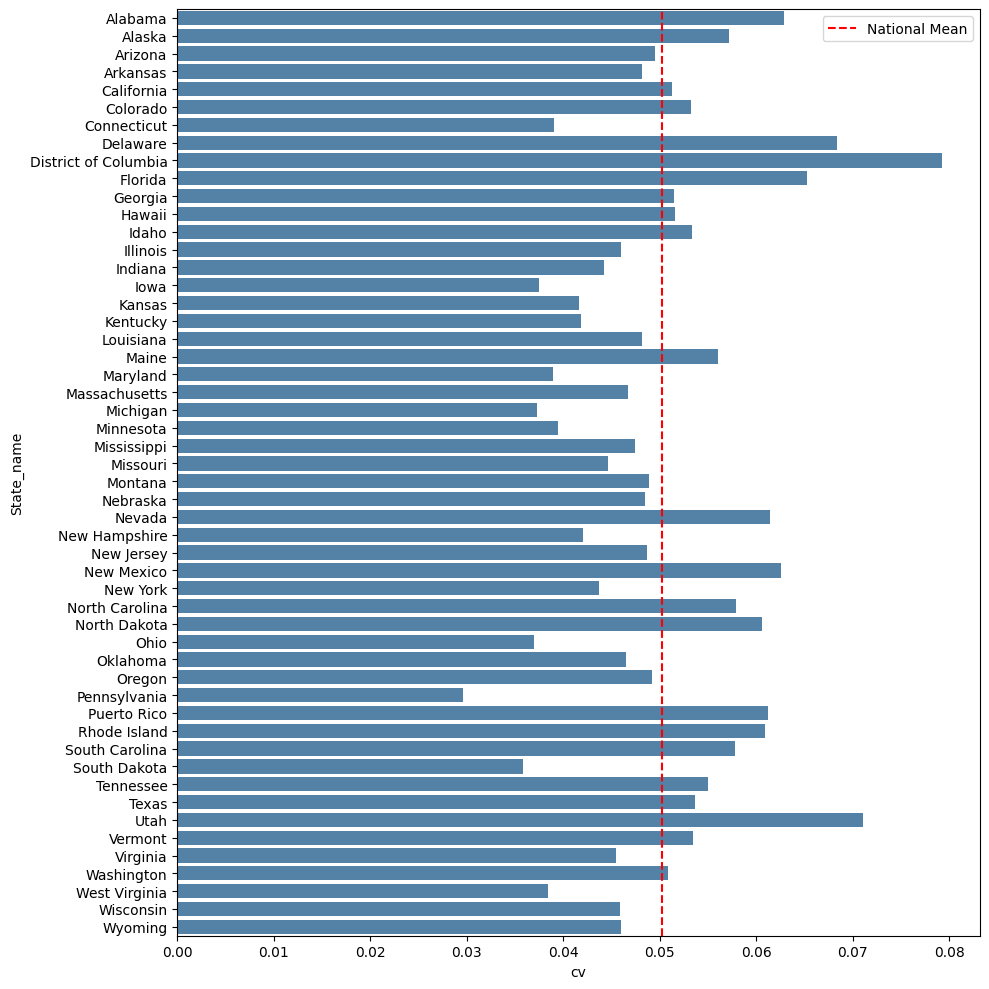

Figure 11. cv for states

The bar plot displays the coefficient of variation for all states, sorted from highest to lowest, with the national CV mean shown as a red dashed line.

Key observations include:

- Several states—District of Columbia, Utah, Delaware, Florida—lie well above the national average, signaling substantial income instability.

- Many states cluster around the national mean, indicating moderate and comparable volatility.

- A number of states lie significantly below the national mean, showing remarkably stable income trajectories over the three years.

The red line helps highlight whether each state’s volatility is above or below national expectations, offering an intuitive benchmark for interpretation.

---

# Key Insights

## EDA:

Overall, the exploratory analysis reveals three key findings. 
1. Income levels vary substantially across states, reflecting regional economic heterogeneity. 
2. Second, the income distribution exhibits only mild skewness, indicating that extreme values do not disproportionately influence summary measures. 
3. Third, median household income shows a consistent upward trend over time, supporting the presence of sustained growth.

# Preprocessing and Feature Engineering:

Across three years of data (2021–2023) and all engineered features, several broad insights emerge:

1. The U.S. experienced a clear macroeconomic cycle: contraction → rebound → stabilization.

2. States do not move uniformly—economic dynamics are heterogeneous, with some states experiencing much more pronounced swings.

3. Temporal features (growth rate, deviation) highlight national-level patterns, while variation features (CV) reveal underlying structural differences across states.

4. Engineered features provide complementary lenses:

   - Deviation shows performance relative to state history

   - Growth shows year-to-year change

   - CV shows long-run stability

Together, these features give a multi-dimensional, statistically grounded view of income dynamics across states.





---

# Conclusion

Our project provides a comprehensive examination of how demographic structure and household income levels interact across U.S. states between 2021 and 2023. Through a tightly integrated workflow—including acquisition of Census PEP and ACS data, rigorous preprocessing, and targeted feature engineering—we constructed a cleaned, well-structured analytic dataset that enabled detailed cross-sectional and temporal comparisons.

### Data Integrity and Preprocessing

The preprocessing pipeline ensured that the merged population–income dataset is consistent, interpretable, and analysis-ready. Key steps—such as harmonizing variable names, standardizing data types, filtering for valid analytic years, and validating the state-year structure of income values—were essential for maintaining data integrity.
For example, the decision to restrict analysis to 2021–2023 eliminated structural missingness arising from ACS coverage gaps and provided a uniform temporal window for fair comparisons across states. The resulting dataset is free of duplicates, contains no missing income values, and preserves the correct hierarchical relationships between demographic subgroups and state-year income aggregates.

### Feature Engineering Enhancements

Feature engineering substantially increased the interpretability and analytical power of the dataset. Notably:

- Age code transformation resolved Census-style codes into meaningful numeric ages, human-readable labels, and broader life-stage groups. This reduced noise from single-year fluctuations and facilitated demographic comparisons across states.

- Relative income metrics, including deviations from national means and within-year z-scores, allowed scale-free comparisons and effectively highlighted outliers and structural state-level inequalities.

- Derived comparative measures, such as within-state income deviations and coefficients of variation, enhanced our ability to characterize volatility and cross-state heterogeneity—insights not available from raw income alone.

These engineered variables transformed a raw merged dataset into a multidimensional structure capable of supporting nuanced economic and demographic interpretations.

### Substantive Analytical Insights

Analyses in the accompanying EDA report reveal several clear and economically meaningful patterns:

- National recovery was uneven:

  - 2021 showed widespread negative growth tied to pandemic-era disruptions.

  - 2022 saw strong positive rebounds, but with heightened variability across states.

  - 2023 exhibited stabilization, declining variance, and fewer extremes, indicating normalization within the national income distribution

- Relative income standings remained structurally persistent:
  High-income states such as Massachusetts, California, and New Jersey consistently exceeded national averages, while states like Mississippi, Louisiana, and West Virginia remained below them.

- Volatility analysis provided deeper insight than raw income levels:
  The coefficient-of-variation ranking demonstrated that high median income does not imply stability. Specifically, states such as the District of Columbia and Utah exhibit high relative volatility despite strong income levels, while several mid-income states maintain remarkably stable income trajectories.
  This indicates that economic resilience is orthogonal to income level, reinforcing the need to consider variability rather than solely absolute values.

### Overall Contribution

By combining preprocessing, feature engineering, and EDA, this project delivers a dataset and analytical framework that accurately captures the interplay between demographic structures and short-run economic conditions across U.S. states. The methodology ensures both reproducibility and extensibility.

Ultimately, the project enables insights into income dynamics, demographic structure, and cross-state disparities that would otherwise remain obscured. This integrated workflow provides a strong foundation for understanding post-pandemic economic transitions, regional variations, and broader socio-economic patterns in the United States.